In [1]:
import os, sys
import collections
import numpy as np
from scipy.special import logsumexp
import matplotlib.markers as markers
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("ticks")
import timeit
from scipy.stats import median_abs_deviation as mad
import pandas as pd
import multiprocessing
import cProfile
import itertools
import warnings

warnings.filterwarnings('ignore')  # this is just to hide all the warnings

import matplotlib.pyplot as plt  # change font globally to Times

plt.style.use('ggplot')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times New Roman",
    "font.sans-serif": ["Times New Roman"],
    "font.size": 12
})

os.chdir(sys.path[0])  # ensure working direcotry is set same as the file

In [2]:
def pasta(a, b):
    '''
    A function that pastes the results all together.
    '''
    c = a.astype(str).copy()
    c = np.char.add(c, np.array([" ("] * a.size).reshape(a.shape))
    c = np.char.add(c, b.astype(str))
    c = np.char.add(c, np.array([")"] * a.size).reshape(a.shape))
    return c

# LM -- Speed
## Iterations required to make same amount of descent
### SCAD

In [3]:
SCAD_sim_results = np.load("./tasks/task1speed/SCAD_sim_results.npy")

SCAD_sim_results_mean = np.around(np.median(SCAD_sim_results, 2), 3)
print("Median:")
print("AG: ", SCAD_sim_results_mean[..., 0])
print("proximal gradient: ", SCAD_sim_results_mean[..., 1])
print("original settings: ", SCAD_sim_results_mean[..., 2])
SCAD_sim_results_se = np.around(mad(SCAD_sim_results, 2) * 1.4826, 3)
print("Scaled MAD: ")
print("AG: ", SCAD_sim_results_se[..., 0])
print("proximal gradinet: ", SCAD_sim_results_se[..., 1])
print("original settings: ", SCAD_sim_results_se[..., 2])

LM_SCAD_iterations_latex = pasta(SCAD_sim_results_mean, SCAD_sim_results_se)

Median:
AG:  [[  9.  14.  23.  26.]
 [ 11.  18.  32.  50.]
 [ 37.  72. 172. 432.]]
proximal gradient:  [[  11.    26.    68.    93.5]
 [  21.    38.   116.   308. ]
 [ 104.   362.  2012.5    inf]]
original settings:  [[ 15.  23.  38.  41.]
 [ 19.  30.  51.  76.]
 [ 60. 111. 260. 657.]]
Scaled MAD: 
AG:  [[ 1.483  0.     1.483  1.483]
 [ 1.483  0.     1.483  1.483]
 [ 1.483  2.965  8.154 25.204]]
proximal gradinet:  [[ 4.448  1.483  5.93   6.672]
 [ 7.413  2.224  6.672 19.274]
 [ 7.413 19.274 88.215    nan]]
original settings:  [[ 1.483  1.483  1.483  1.483]
 [ 1.483  1.483  1.483  2.965]
 [ 2.965  4.448 11.861 37.065]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


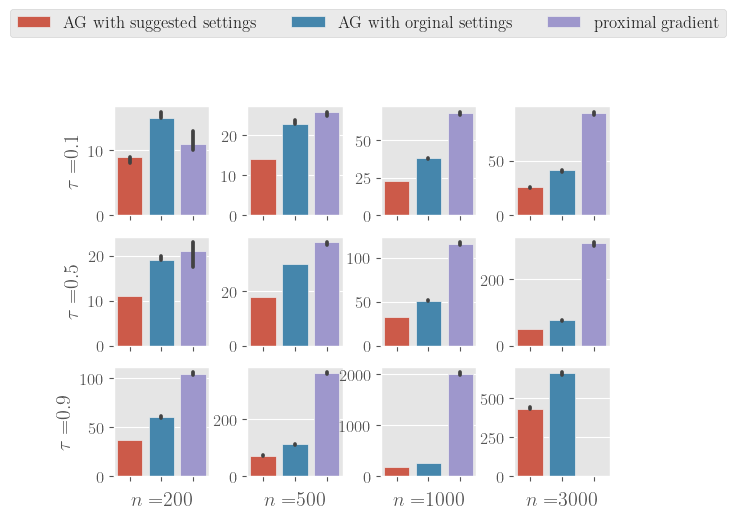

In [4]:
fig, axes = plt.subplots(3, 4)

tau = np.array([.1, .5, .9])
N = np.array([200, 500, 1000, 3000])

for i, j in itertools.product(range(3), range(4)):
    df = pd.DataFrame(columns=[
        'AG with suggested settings', 'proximal gradient',
        'AG with orginal settings'
    ],
                      data=SCAD_sim_results[i, j, :, :3])
    df_melted = pd.melt(df,
                        id_vars=[],
                        value_vars=[
                            'AG with suggested settings',
                            'AG with orginal settings', 'proximal gradient'
                        ],
                        var_name='method',
                        value_name='k')
    #     sns.boxplot(ax=axes[i, j], data=df_melted, x="method", y="k", hue="method", showfliers = False)#.set_title(r'$\tau=$'+str(tau[i])+'$, N=$'+str(N[j]))
    sns.barplot(ax=axes[i, j],
                data=df_melted,
                x="method",
                y="k",
                hue="method",
                estimator=np.median,
                ci=95,
                dodge=False)  #, palette = "Greys")
    if i == 2 and j != 0:
        axes[i, j].set(xticklabels=[], xlabel=r"$n=$" + str(N[j]),
                       ylabel=None)  # yticklabels=[] to remove y scales
    if j == 0 and i != 2:
        axes[i, j].set(xticklabels=[],
                       xlabel=None,
                       ylabel=r"$\tau=$" + str(tau[i]))
    axes[2, 0].set(xticklabels=[],
                   xlabel=r"$n=$" + str(N[0]),
                   ylabel=r"$\tau=$" + str(tau[2]))
    if i != 2 and j != 0:
        axes[i, j].set(xticklabels=[], xlabel=None, ylabel=None)

    axes[i, j].get_legend().remove()

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles,
           labels,
           loc='upper left',
           ncol=3,
           bbox_to_anchor=(-.05, 1.1))
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=.4,
                    hspace=None)

#plt.tight_layout()
plt.savefig('LM-fig_k_SCAD.eps', format='eps', dpi=600, bbox_inches='tight')
plt.show()

### MCP

In [5]:
MCP_sim_results = np.load("./tasks/task1speed/MCP_sim_results.npy")

MCP_sim_results_mean = np.around(np.median(MCP_sim_results, 2), 3)
print("Median:")
print("AG: ", MCP_sim_results_mean[..., 0])
print("proximal gradient: ", MCP_sim_results_mean[..., 1])
print("original settings: ", MCP_sim_results_mean[..., 2])
MCP_sim_results_se = np.around(mad(MCP_sim_results, 2) * 1.4826, 3)
print("Scaled MAD: ")
print("AG: ", MCP_sim_results_se[..., 0])
print("proximal gradient: ", MCP_sim_results_se[..., 1])
print("original settings: ", MCP_sim_results_se[..., 2])

LM_MCP_iterations_latex = pasta(MCP_sim_results_mean, MCP_sim_results_se)

Median:
AG:  [[  6.   10.   17.   25. ]
 [ 10.   15.   26.   48. ]
 [ 31.   68.  152.  428.5]]
proximal gradient:  [[   7.    16.    48.    90. ]
 [  12.    28.    94.   289.5]
 [  82.   345.  1897.5    inf]]
original settings:  [[  9.   18.   29.   40. ]
 [ 17.   26.   42.   74.5]
 [ 50.  104.  226.5 657. ]]
Scaled MAD: 
AG:  [[ 1.483  0.     0.     1.483]
 [ 1.483  0.741  1.483  1.483]
 [ 1.483  2.965  7.413 24.463]]
proximal gradient:  [[ 1.483  0.     2.965  5.93 ]
 [ 2.965  1.483  5.93  17.05 ]
 [ 5.93  19.274 85.991    nan]]
original settings:  [[ 0.     1.483  1.483  1.483]
 [ 1.483  1.483  1.483  2.224]
 [ 1.483  3.706 10.378 37.065]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


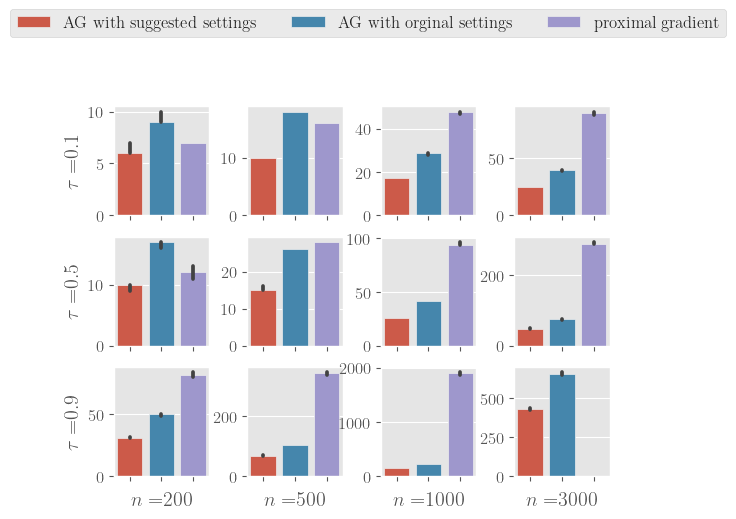

In [6]:
fig, axes = plt.subplots(3, 4)

tau = np.array([.1, .5, .9])
N = np.array([200, 500, 1000, 3000])

for i, j in itertools.product(range(3), range(4)):
    df = pd.DataFrame(columns=[
        'AG with suggested settings', 'proximal gradient',
        'AG with orginal settings'
    ],
                      data=MCP_sim_results[i, j, :, :3])
    df_melted = pd.melt(df,
                        id_vars=[],
                        value_vars=[
                            'AG with suggested settings',
                            'AG with orginal settings', 'proximal gradient'
                        ],
                        var_name='method',
                        value_name='k')
    #     sns.boxplot(ax=axes[i, j], data=df_melted, x="method", y="k", hue="method", showfliers = False)#.set_title(r'$\tau=$'+str(tau[i])+'$, N=$'+str(N[j]))
    sns.barplot(ax=axes[i, j],
                data=df_melted,
                x="method",
                y="k",
                hue="method",
                estimator=np.median,
                ci=95,
                dodge=False)  #, palette = "Greys")
    if i == 2 and j != 0:
        axes[i, j].set(xticklabels=[], xlabel=r"$n=$" + str(N[j]),
                       ylabel=None)  # yticklabels=[] to remove y scales
    if j == 0 and i != 2:
        axes[i, j].set(xticklabels=[],
                       xlabel=None,
                       ylabel=r"$\tau=$" + str(tau[i]))
    axes[2, 0].set(xticklabels=[],
                   xlabel=r"$n=$" + str(N[0]),
                   ylabel=r"$\tau=$" + str(tau[2]))
    if i != 2 and j != 0:
        axes[i, j].set(xticklabels=[], xlabel=None, ylabel=None)

    axes[i, j].get_legend().remove()

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles,
           labels,
           loc='upper left',
           ncol=3,
           bbox_to_anchor=(-.05, 1.1))
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=.4,
                    hspace=None)

#plt.tight_layout()
plt.savefig('LM-fig_k_MCP.eps', format='eps', dpi=600, bbox_inches='tight')
plt.show()

## Computing time
### SCAD

Median:
AG:  [[ 0.374  0.533  1.361  1.924]
 [ 0.457  0.622  1.561  1.829]
 [ 0.959  2.609  7.614 12.124]]
proximal gradient:  [[ 0.957  1.173  1.861 10.279]
 [ 1.299  1.435  2.336  6.481]
 [ 2.929  3.519  9.861 10.21 ]]
coordinate descent:  [[  15.688   17.421   28.749  114.427]
 [  16.648   18.064   43.481  195.019]
 [  19.179   51.266  215.513 1084.178]]
Scaled MAD: 
AG:  [[0.089 0.12  0.209 0.562]
 [0.081 0.119 0.135 0.222]
 [0.13  0.108 0.329 0.135]]
proximal gradient:  [[0.256 0.435 0.538 0.277]
 [0.283 0.441 0.504 1.946]
 [0.772 0.718 0.133 0.141]]
coordinate descent:  [[ 1.646  2.51   2.093  4.527]
 [ 2.424  2.86   1.982  8.179]
 [ 4.49   1.373  9.553 46.196]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


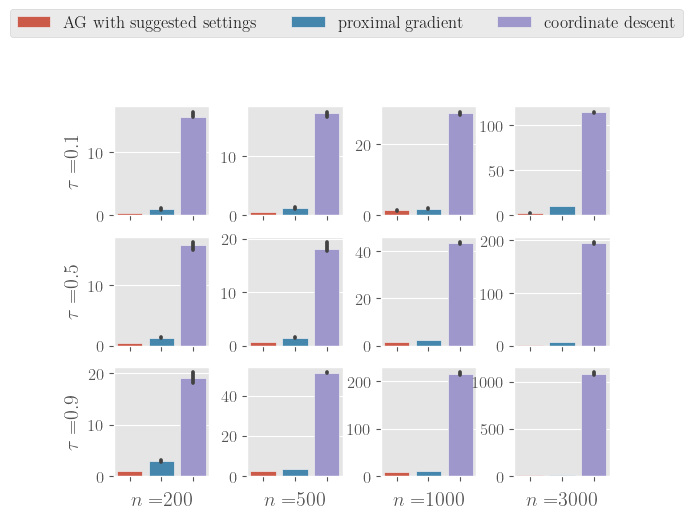

In [7]:
SCAD_sim_results = np.load("./tasks/task1speed/SCAD_sim_results.npy")

SCAD_sim_results_mean = np.around(np.median(SCAD_sim_results, 2), 3)
print("Median:")
print("AG: ", SCAD_sim_results_mean[..., 3])
print("proximal gradient: ", SCAD_sim_results_mean[..., 4])
print("coordinate descent: ", SCAD_sim_results_mean[..., 5])
SCAD_sim_results_se = np.around(mad(SCAD_sim_results, 2) * 1.4826, 3)
print("Scaled MAD: ")
print("AG: ", SCAD_sim_results_se[..., 3])
print("proximal gradient: ", SCAD_sim_results_se[..., 4])
print("coordinate descent: ", SCAD_sim_results_se[..., 5])

fig, axes = plt.subplots(3, 4)

tau = np.array([.1, .5, .9])
N = np.array([200, 500, 1000, 3000])

for i, j in itertools.product(range(3), range(4)):
    df = pd.DataFrame(columns=[
        'AG with suggested settings', 'proximal gradient', 'coordinate descent'
    ],
                      data=SCAD_sim_results[i, j, :, 3:])
    df_melted = pd.melt(df,
                        id_vars=[],
                        value_vars=[
                            'AG with suggested settings', 'proximal gradient',
                            'coordinate descent'
                        ],
                        var_name='method',
                        value_name='k')
    #     sns.boxplot(ax=axes[i, j], data=df_melted, x="method", y="k", hue="method", showfliers = False)#.set_title(r'$\tau=$'+str(tau[i])+'$, N=$'+str(N[j]))
    sns.barplot(ax=axes[i, j],
                data=df_melted,
                x="method",
                y="k",
                hue="method",
                estimator=np.median,
                ci=95,
                dodge=False)  #, palette = "Greys")
    if i == 2 and j != 0:
        axes[i, j].set(xticklabels=[], xlabel=r"$n=$" + str(N[j]),
                       ylabel=None)  # yticklabels=[] to remove y scales
    if j == 0 and i != 2:
        axes[i, j].set(xticklabels=[],
                       xlabel=None,
                       ylabel=r"$\tau=$" + str(tau[i]))
    axes[2, 0].set(xticklabels=[],
                   xlabel=r"$n=$" + str(N[0]),
                   ylabel=r"$\tau=$" + str(tau[2]))
    if i != 2 and j != 0:
        axes[i, j].set(xticklabels=[], xlabel=None, ylabel=None)

    axes[i, j].get_legend().remove()

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles,
           labels,
           loc='upper left',
           ncol=3,
           bbox_to_anchor=(-.05, 1.1))
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=.4,
                    hspace=None)

#plt.tight_layout()
plt.savefig('LM-time_SCAD.eps', format='eps', dpi=600, bbox_inches='tight')
plt.show()

LM_SCAD_computing_time_latex = pasta(SCAD_sim_results_mean,
                                     SCAD_sim_results_se)

### MCP

Median:
AG:  [[ 0.292  0.409  0.887  1.52 ]
 [ 0.351  0.485  1.106  1.634]
 [ 0.785  2.127  6.213 10.406]]
proximal gradient:  [[0.724 0.892 1.298 7.725]
 [0.995 1.091 1.565 5.555]
 [2.383 2.69  8.126 8.493]]
coordinate descent:  [[ 13.493  15.052  23.986  94.093]
 [ 14.4    15.389  35.111 159.852]
 [ 16.403  41.808 178.715 893.526]]
Scaled MAD: 
AG:  [[0.051 0.102 0.122 0.508]
 [0.075 0.096 0.056 0.195]
 [0.1   0.079 0.254 0.121]]
prximal gradient:  [[0.194 0.275 0.352 1.421]
 [0.243 0.272 0.392 1.557]
 [0.503 0.468 0.083 0.082]]
coordinate descent:  [[ 2.423  2.981  2.061  4.478]
 [ 2.984  3.784  1.603  7.327]
 [ 2.631  1.275  7.689 35.013]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


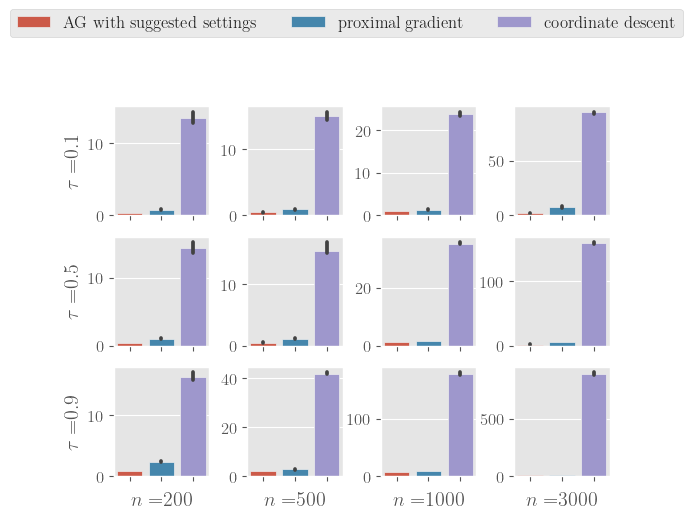

In [8]:
MCP_sim_results = np.load("./tasks/task1speed/MCP_sim_results.npy")

MCP_sim_results_mean = np.around(np.median(MCP_sim_results, 2), 3)
print("Median:")
print("AG: ", MCP_sim_results_mean[..., 3])
print("proximal gradient: ", MCP_sim_results_mean[..., 4])
print("coordinate descent: ", MCP_sim_results_mean[..., 5])
MCP_sim_results_se = np.around(mad(MCP_sim_results, 2) * 1.4826, 3)
print("Scaled MAD: ")
print("AG: ", MCP_sim_results_se[..., 3])
print("prximal gradient: ", MCP_sim_results_se[..., 4])
print("coordinate descent: ", MCP_sim_results_se[..., 5])

fig, axes = plt.subplots(3, 4)

tau = np.array([.1, .5, .9])
N = np.array([200, 500, 1000, 3000])

for i, j in itertools.product(range(3), range(4)):
    df = pd.DataFrame(columns=[
        'AG with suggested settings', 'proximal gradient', 'coordinate descent'
    ],
                      data=MCP_sim_results[i, j, :, 3:])
    df_melted = pd.melt(df,
                        id_vars=[],
                        value_vars=[
                            'AG with suggested settings', 'proximal gradient',
                            'coordinate descent'
                        ],
                        var_name='method',
                        value_name='k')
    #     sns.boxplot(ax=axes[i, j], data=df_melted, x="method", y="k", hue="method", showfliers = False)#.set_title(r'$\tau=$'+str(tau[i])+'$, N=$'+str(N[j]))
    sns.barplot(ax=axes[i, j],
                data=df_melted,
                x="method",
                y="k",
                hue="method",
                estimator=np.median,
                ci=95,
                dodge=False)  #, palette = "Greys")
    if i == 2 and j != 0:
        axes[i, j].set(xticklabels=[], xlabel=r"$n=$" + str(N[j]),
                       ylabel=None)  # yticklabels=[] to remove y scales
    if j == 0 and i != 2:
        axes[i, j].set(xticklabels=[],
                       xlabel=None,
                       ylabel=r"$\tau=$" + str(tau[i]))
    axes[2, 0].set(xticklabels=[],
                   xlabel=r"$n=$" + str(N[0]),
                   ylabel=r"$\tau=$" + str(tau[2]))
    if i != 2 and j != 0:
        axes[i, j].set(xticklabels=[], xlabel=None, ylabel=None)

    axes[i, j].get_legend().remove()

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles,
           labels,
           loc='upper left',
           ncol=3,
           bbox_to_anchor=(-.05, 1.1))
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=.4,
                    hspace=None)

#plt.tight_layout()
plt.savefig('LM-time_MCP.eps', format='eps', dpi=600, bbox_inches='tight')
plt.show()

LM_MCP_computing_time_latex = pasta(MCP_sim_results_mean, MCP_sim_results_se)

# LM -- Signals
## SCAD
### AG

In [9]:
results_SCAD_signal_recovery = np.load(
    "./tasks/task1/results_SCAD_signal_recovery.npy")

results_SCAD_signal_recovery_mean = np.around(
    np.mean(results_SCAD_signal_recovery, 2), 3)
results_SCAD_signal_recovery_se = np.around(
    np.std(results_SCAD_signal_recovery, 2), 3)
print("Sample mean:")
print(
    "2-norm: ",
    pasta(results_SCAD_signal_recovery_mean[..., 0],
          results_SCAD_signal_recovery_se[..., 0]))
print(
    "infinity-norm: ",
    pasta(results_SCAD_signal_recovery_mean[..., 1],
          results_SCAD_signal_recovery_se[..., 1]))
print(
    "PPV: ",
    pasta(results_SCAD_signal_recovery_mean[..., 2],
          results_SCAD_signal_recovery_se[..., 2]))
print(
    "NPV: ",
    pasta(results_SCAD_signal_recovery_mean[..., 3],
          results_SCAD_signal_recovery_se[..., 3]))
print(
    "active set cardi: ",
    pasta(results_SCAD_signal_recovery_mean[..., 4],
          results_SCAD_signal_recovery_se[..., 4]))

# results_SCAD_signal_recovery_median = cp.median(results_SCAD_signal_recovery, 2)
# print("Sample median:")
# print("2-norm: ",results_SCAD_signal_recovery_median[...,0])
# print("infinity-norm: ",results_SCAD_signal_recovery_median[...,1])
# print("sensitivity: ",results_SCAD_signal_recovery_median[...,2])
# print("specificity: ",results_SCAD_signal_recovery_median[...,3])
# results_SCAD_signal_recovery_mad = mad(results_SCAD_signal_recovery.get(), 2)*1.4826
# print("Scaled MAD:")
# print("2-norm: ",results_SCAD_signal_recovery_mad[...,0])
# print("infinity-norm: ",results_SCAD_signal_recovery_mad[...,1])
# print("sensitivity: ",results_SCAD_signal_recovery_mad[...,2])
# print("specificity: ",results_SCAD_signal_recovery_mad[...,3])

LM_SCAD_signal_latex = pasta(results_SCAD_signal_recovery_mean,
                             results_SCAD_signal_recovery_se)

Sample mean:
2-norm:  [['0.129 (0.021)' '0.504 (0.103)' '2.859 (0.493)']
 ['0.051 (0.009)' '0.155 (0.027)' '2.038 (0.328)']
 ['0.022 (0.004)' '0.084 (0.014)' '1.27 (0.272)']
 ['0.016 (0.003)' '0.063 (0.012)' '1.167 (0.199)']]
infinity-norm:  [['21.447 (2.798)' '48.472 (5.353)' '159.96 (35.95)']
 ['13.229 (2.62)' '24.778 (4.233)' '114.446 (21.17)']
 ['8.925 (2.024)' '17.917 (2.597)' '75.972 (15.129)']
 ['7.631 (1.934)' '16.107 (2.508)' '71.532 (11.583)']]
PPV:  [['0.751 (0.13)' '0.587 (0.19)' '0.493 (0.252)']
 ['0.646 (0.168)' '0.544 (0.2)' '0.343 (0.243)']
 ['0.546 (0.149)' '0.411 (0.249)' '0.202 (0.157)']
 ['0.512 (0.266)' '0.429 (0.096)' '0.208 (0.086)']]
NPV:  [['0.984 (0.001)' '0.984 (0.001)' '0.979 (0.001)']
 ['0.989 (0.001)' '0.988 (0.001)' '0.98 (0.001)']
 ['0.992 (0.001)' '0.991 (0.001)' '0.982 (0.001)']
 ['0.993 (0.001)' '0.992 (0.001)' '0.982 (0.001)']]
active set cardi:  [['25.04 (8.315)' '34.84 (19.22)' '23.06 (17.038)']
 ['46.13 (17.272)' '57.27 (25.66)' '42.53 (16.81)']
 

### ncvreg

In [10]:
results_SCAD_signal_recovery = np.load(
    "./SCAD_MCP/LM/R_results_SCAD_signal_recovery.npy")

results_SCAD_signal_recovery = np.reshape(results_SCAD_signal_recovery,
                                          (4, 3, 100, 5),
                                          "F")  # keep array dimension true
results_SCAD_signal_recovery_mean = np.around(
    np.mean(results_SCAD_signal_recovery, 2), 3)
results_SCAD_signal_recovery_se = np.around(
    np.std(results_SCAD_signal_recovery, 2), 3)
print("Sample mean:")
print(
    "2-norm: ",
    pasta(results_SCAD_signal_recovery_mean[..., 0],
          results_SCAD_signal_recovery_se[..., 0]))
print(
    "infinity-norm: ",
    pasta(results_SCAD_signal_recovery_mean[..., 1],
          results_SCAD_signal_recovery_se[..., 1]))
print(
    "PPV: ",
    pasta(results_SCAD_signal_recovery_mean[..., 2],
          results_SCAD_signal_recovery_se[..., 2]))
print(
    "NPV: ",
    pasta(results_SCAD_signal_recovery_mean[..., 3],
          results_SCAD_signal_recovery_se[..., 3]))
print(
    "active set cardi: ",
    pasta(results_SCAD_signal_recovery_mean[..., 4],
          results_SCAD_signal_recovery_se[..., 4]))

ncvreg_LM_SCAD_signal_latex = pasta(results_SCAD_signal_recovery_mean,
                                    results_SCAD_signal_recovery_se)

# results_SCAD_signal_recovery_median = cp.median(results_SCAD_signal_recovery, 2)
# print("Sample median:")
# print("2-norm: ",results_SCAD_signal_recovery_median[...,0])
# print("infinity-norm: ",results_SCAD_signal_recovery_median[...,1])
# print("sensitivity: ",results_SCAD_signal_recovery_median[...,2])
# print("specificity: ",results_SCAD_signal_recovery_median[...,3])
# results_SCAD_signal_recovery_mad = mad(results_SCAD_signal_recovery.get(), 2)*1.4826
# print("Scaled MAD:")
# print("2-norm: ",results_SCAD_signal_recovery_mad[...,0])
# print("infinity-norm: ",results_SCAD_signal_recovery_mad[...,1])
# print("sensitivity: ",results_SCAD_signal_recovery_mad[...,2])
# print("specificity: ",results_SCAD_signal_recovery_mad[...,3])

Sample mean:
2-norm:  [['0.131 (0.02)' '0.493 (0.101)' '2.932 (0.577)']
 ['0.053 (0.009)' '0.157 (0.029)' '2.082 (0.336)']
 ['0.022 (0.004)' '0.083 (0.014)' '1.297 (0.257)']
 ['0.016 (0.003)' '0.063 (0.012)' '1.152 (0.214)']]
infinity-norm:  [['20.412 (2.843)' '47.143 (5.548)' '170.276 (39.395)']
 ['13.257 (2.263)' '25.142 (4.71)' '116.379 (21.92)']
 ['8.465 (1.496)' '17.806 (2.587)' '78.868 (14.161)']
 ['7.131 (1.202)' '16.144 (2.218)' '72.398 (11.701)']]
PPV:  [['0.254 (0.078)' '0.277 (0.123)' '0.287 (0.201)']
 ['0.279 (0.073)' '0.305 (0.104)' '0.263 (0.138)']
 ['0.32 (0.072)' '0.34 (0.142)' '0.21 (0.157)']
 ['0.343 (0.131)' '0.406 (0.075)' '0.208 (0.056)']]
NPV:  [['0.987 (0.001)' '0.986 (0.001)' '0.98 (0.001)']
 ['0.99 (0.001)' '0.989 (0.001)' '0.98 (0.001)']
 ['0.992 (0.001)' '0.991 (0.001)' '0.982 (0.001)']
 ['0.993 (0.001)' '0.992 (0.001)' '0.982 (0.001)']]
active set cardi:  [['102.26 (29.113)' '93.94 (37.748)' '43.23 (22.821)']
 ['119.93 (34.998)' '104.09 (30.726)' '47.91 (15.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


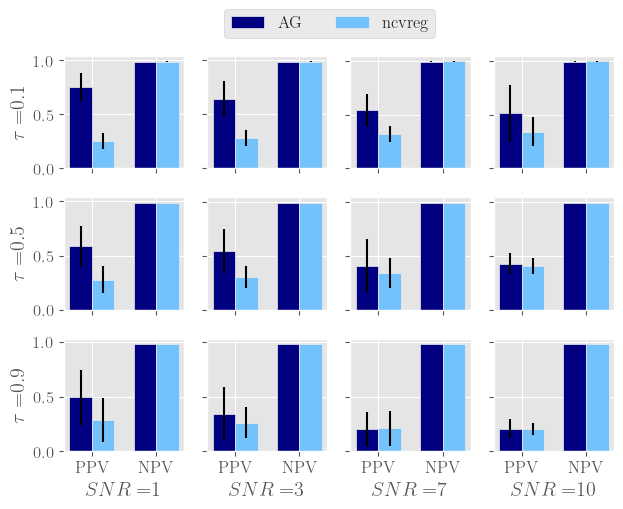

In [11]:
AG = np.load("./tasks/task1/results_SCAD_signal_recovery.npy")
AG_mean = np.mean(AG, 2)
AG_se = np.std(AG, 2)
ncvreg = np.load("./SCAD_MCP/LM/R_results_SCAD_signal_recovery.npy")
ncvreg = np.reshape(ncvreg, (4, 3, 100, 5), "F")  # keep array dimension true
ncvreg_mean = np.mean(ncvreg, 2)
ncvreg_se = np.std(ncvreg, 2)

fig, axes = plt.subplots(3, 4)

tau = np.array([.1, .5, .9])
SNR = np.array([1, 3, 7, 10])

for i, j in itertools.product(range(3), range(4)):
    data = np.array([[AG_mean[j, i, 2], ncvreg_mean[j, i, 2]],
                     [AG_mean[j, i, 3], ncvreg_mean[j, i, 3]]])
    data_se = np.array([[AG_se[j, i, 2], ncvreg_se[j, i, 2]],
                        [AG_se[j, i, 3], ncvreg_se[j, i, 3]]])
    length = len(data)
    x_labels = ["PPV", "NPV"]
    width = 0.35  # width of bar
    x = np.arange(length)
    axes[i, j].bar(x,
                   data[:, 0],
                   width,
                   color='#000080',
                   label='AG',
                   yerr=data_se[:, 0])
    axes[i, j].bar(x + width,
                   data[:, 1],
                   width,
                   color='#73C2FB',
                   label='ncvreg',
                   yerr=data_se[:, 1])
    #     ax.set_ylabel('Proportion')
    #     ax.set_ylim(0,75)
    axes[i, j].set_xticks(x + width / 2)
    axes[i, j].set_xticklabels(x_labels)
    axes[i, j].set_xlabel('Predicted Values')
    #     ax.set_title('Title')
    #     axes[i,j].legend()

    if i == 2 and j != 0:
        axes[i, j].set(xticklabels=x_labels,
                       xlabel=r"$SNR=$" + str(SNR[j]),
                       ylabel=None)  # yticklabels=[] to remove y scales
    if j == 0 and i != 2:
        axes[i, j].set(xticklabels=x_labels,
                       xlabel=None,
                       ylabel=r"$\tau=$" + str(tau[i]))
    axes[2, 0].set(xticklabels=x_labels,
                   xlabel=r"$SNR=$" + str(SNR[0]),
                   ylabel=r"$\tau=$" + str(tau[2]))
    if i != 2 and j != 0:
        axes[i, j].set(xticklabels=x_labels, xlabel=None, ylabel=None)

for ax in axes.flat:
    ax.label_outer()

# plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
fig.tight_layout(pad=.2)
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles,
           labels,
           loc='upper left',
           ncol=4,
           bbox_to_anchor=(.35, 1.075))

plt.tight_layout()
plt.savefig('LM-SCAD-pv.eps', format='eps', dpi=600, bbox_inches='tight')
plt.show()

## MCP
### AG

In [12]:
results_MCP_signal_recovery = np.load(
    "./tasks/task1/results_MCP_signal_recovery.npy")

results_MCP_signal_recovery_mean = np.around(
    np.mean(results_MCP_signal_recovery, 2), 3)
results_MCP_signal_recovery_se = np.around(
    np.std(results_MCP_signal_recovery, 2), 3)
print("Sample mean:")
print(
    "2-norm: ",
    pasta(results_MCP_signal_recovery_mean[..., 0],
          results_MCP_signal_recovery_se[..., 0]))
print(
    "infinity-norm: ",
    pasta(results_MCP_signal_recovery_mean[..., 1],
          results_MCP_signal_recovery_se[..., 1]))
print(
    "PPV: ",
    pasta(results_MCP_signal_recovery_mean[..., 2],
          results_MCP_signal_recovery_se[..., 2]))
print(
    "NPV: ",
    pasta(results_MCP_signal_recovery_mean[..., 3],
          results_MCP_signal_recovery_se[..., 3]))
print(
    "active set cardi: ",
    pasta(results_MCP_signal_recovery_mean[..., 4],
          results_MCP_signal_recovery_se[..., 4]))

LM_MCP_signal_latex = pasta(results_MCP_signal_recovery_mean,
                            results_MCP_signal_recovery_se)

# results_MCP_signal_recovery_median = cp.median(results_MCP_signal_recovery, 2)
# print("Sample median:")
# print("2-norm: ",results_MCP_signal_recovery_median[...,0])
# print("infinity-norm: ",results_MCP_signal_recovery_median[...,1])
# print("sensitivity: ",results_MCP_signal_recovery_median[...,2])
# print("specificity: ",results_MCP_signal_recovery_median[...,3])
# results_MCP_signal_recovery_mad = mad(results_MCP_signal_recovery.get(), 2)*1.4826
# print("Scaled MAD:")
# print("2-norm: ",results_MCP_signal_recovery_mad[...,0])
# print("infinity-norm: ",results_MCP_signal_recovery_mad[...,1])
# print("sensitivity: ",results_MCP_signal_recovery_mad[...,2])
# print("specificity: ",results_MCP_signal_recovery_mad[...,3])

Sample mean:
2-norm:  [['0.134 (0.024)' '0.543 (0.117)' '2.955 (0.51)']
 ['0.05 (0.01)' '0.168 (0.032)' '1.946 (0.333)']
 ['0.022 (0.004)' '0.088 (0.015)' '1.507 (0.3)']
 ['0.015 (0.003)' '0.059 (0.012)' '1.079 (0.285)']]
infinity-norm:  [['22.688 (2.928)' '50.134 (5.825)' '163.886 (35.84)']
 ['14.011 (2.744)' '25.204 (4.825)' '107.147 (19.601)']
 ['8.933 (2.029)' '18.473 (2.999)' '86.237 (17.206)']
 ['7.721 (2.016)' '15.002 (3.023)' '68.41 (13.265)']]
PPV:  [['0.855 (0.095)' '0.738 (0.16)' '0.687 (0.181)']
 ['0.842 (0.109)' '0.724 (0.216)' '0.445 (0.28)']
 ['0.759 (0.171)' '0.667 (0.287)' '0.506 (0.212)']
 ['0.794 (0.105)' '0.479 (0.123)' '0.352 (0.198)']]
NPV:  [['0.983 (0.001)' '0.982 (0.001)' '0.978 (0.0)']
 ['0.987 (0.001)' '0.986 (0.001)' '0.98 (0.001)']
 ['0.991 (0.001)' '0.989 (0.001)' '0.981 (0.001)']
 ['0.992 (0.001)' '0.99 (0.001)' '0.982 (0.001)']]
active set cardi:  [['19.48 (4.959)' '20.98 (8.748)' '10.14 (6.408)']
 ['30.29 (7.835)' '35.32 (16.366)' '29.45 (14.845)']
 ['4

### ncvreg

In [13]:
results_MCP_signal_recovery = np.load(
    "./SCAD_MCP/LM/R_results_MCP_signal_recovery.npy")

results_MCP_signal_recovery = np.reshape(results_MCP_signal_recovery,
                                         (4, 3, 100, 5),
                                         "F")  # keep array dimension true
results_MCP_signal_recovery_mean = np.around(
    np.mean(results_MCP_signal_recovery, 2), 3)
results_MCP_signal_recovery_se = np.around(
    np.std(results_MCP_signal_recovery, 2), 3)
print("Sample mean:")
print(
    "2-norm: ",
    pasta(results_MCP_signal_recovery_mean[..., 0],
          results_MCP_signal_recovery_se[..., 0]))
print(
    "infinity-norm: ",
    pasta(results_MCP_signal_recovery_mean[..., 1],
          results_MCP_signal_recovery_se[..., 1]))
print(
    "PPV: ",
    pasta(results_MCP_signal_recovery_mean[..., 2],
          results_MCP_signal_recovery_se[..., 2]))
print(
    "NPV: ",
    pasta(results_MCP_signal_recovery_mean[..., 3],
          results_MCP_signal_recovery_se[..., 3]))
print(
    "active set cardi: ",
    pasta(results_MCP_signal_recovery_mean[..., 4],
          results_MCP_signal_recovery_se[..., 4]))

ncvreg_LM_MCP_signal_latex = pasta(results_MCP_signal_recovery_mean,
                                   results_MCP_signal_recovery_se)

# results_MCP_signal_recovery_median = cp.median(results_MCP_signal_recovery, 2)
# print("Sample median:")
# print("2-norm: ",results_MCP_signal_recovery_median[...,0])
# print("infinity-norm: ",results_MCP_signal_recovery_median[...,1])
# print("sensitivity: ",results_MCP_signal_recovery_median[...,2])
# print("specificity: ",results_MCP_signal_recovery_median[...,3])
# results_MCP_signal_recovery_mad = mad(results_MCP_signal_recovery.get(), 2)*1.4826
# print("Scaled MAD:")
# print("2-norm: ",results_MCP_signal_recovery_mad[...,0])
# print("infinity-norm: ",results_MCP_signal_recovery_mad[...,1])
# print("sensitivity: ",results_MCP_signal_recovery_mad[...,2])
# print("specificity: ",results_MCP_signal_recovery_mad[...,3])

Sample mean:
2-norm:  [['0.127 (0.021)' '0.495 (0.112)' '2.848 (0.375)']
 ['0.05 (0.009)' '0.164 (0.033)' '1.876 (0.337)']
 ['0.021 (0.004)' '0.085 (0.014)' '1.443 (0.261)']
 ['0.014 (0.003)' '0.059 (0.012)' '1.104 (0.211)']]
infinity-norm:  [['20.793 (2.687)' '47.928 (6.042)' '160.78 (30.234)']
 ['13.448 (2.454)' '24.955 (4.365)' '102.795 (20.161)']
 ['8.43 (1.508)' '18.067 (2.806)' '83.569 (16.416)']
 ['7.181 (1.098)' '15.222 (2.679)' '68.253 (11.907)']]
PPV:  [['0.439 (0.105)' '0.392 (0.119)' '0.385 (0.178)']
 ['0.489 (0.102)' '0.479 (0.117)' '0.37 (0.18)']
 ['0.536 (0.131)' '0.538 (0.173)' '0.499 (0.211)']
 ['0.56 (0.113)' '0.468 (0.121)' '0.352 (0.211)']]
NPV:  [['0.985 (0.001)' '0.984 (0.001)' '0.979 (0.0)']
 ['0.989 (0.001)' '0.987 (0.001)' '0.98 (0.001)']
 ['0.992 (0.001)' '0.989 (0.001)' '0.981 (0.001)']
 ['0.992 (0.001)' '0.99 (0.001)' '0.982 (0.001)']]
active set cardi:  [['50.47 (13.225)' '48.19 (16.776)' '20.66 (10.277)']
 ['60.66 (14.629)' '52.69 (16.156)' '31.23 (14.271)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


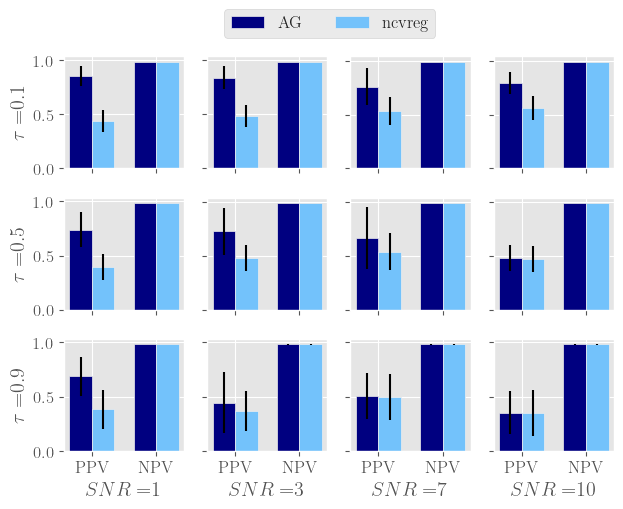

In [14]:
AG = np.load("./tasks/task1/results_MCP_signal_recovery.npy")
AG_mean = np.mean(AG, 2)
AG_se = np.std(AG, 2)
ncvreg = np.load("./SCAD_MCP/LM/R_results_MCP_signal_recovery.npy")
ncvreg = np.reshape(ncvreg, (4, 3, 100, 5), "F")  # keep array dimension true
ncvreg_mean = np.mean(ncvreg, 2)
ncvreg_se = np.std(ncvreg, 2)

fig, axes = plt.subplots(3, 4)

tau = np.array([.1, .5, .9])
SNR = np.array([1, 3, 7, 10])

for i, j in itertools.product(range(3), range(4)):
    data = np.array([[AG_mean[j, i, 2], ncvreg_mean[j, i, 2]],
                     [AG_mean[j, i, 3], ncvreg_mean[j, i, 3]]])
    data_se = np.array([[AG_se[j, i, 2], ncvreg_se[j, i, 2]],
                        [AG_se[j, i, 3], ncvreg_se[j, i, 3]]])
    length = len(data)
    x_labels = ["PPV", "NPV"]
    width = 0.35  # width of bar
    x = np.arange(length)
    axes[i, j].bar(x,
                   data[:, 0],
                   width,
                   color='#000080',
                   label='AG',
                   yerr=data_se[:, 0])
    axes[i, j].bar(x + width,
                   data[:, 1],
                   width,
                   color='#73C2FB',
                   label='ncvreg',
                   yerr=data_se[:, 1])
    #     ax.set_ylabel('Proportion')
    #     ax.set_ylim(0,75)
    axes[i, j].set_xticks(x + width / 2)
    axes[i, j].set_xticklabels(x_labels)
    axes[i, j].set_xlabel('Predicted Values')
    #     ax.set_title('Title')
    #     axes[i,j].legend()

    if i == 2 and j != 0:
        axes[i, j].set(xticklabels=x_labels,
                       xlabel=r"$SNR=$" + str(SNR[j]),
                       ylabel=None)  # yticklabels=[] to remove y scales
    if j == 0 and i != 2:
        axes[i, j].set(xticklabels=x_labels,
                       xlabel=None,
                       ylabel=r"$\tau=$" + str(tau[i]))
    axes[2, 0].set(xticklabels=x_labels,
                   xlabel=r"$SNR=$" + str(SNR[0]),
                   ylabel=r"$\tau=$" + str(tau[2]))
    if i != 2 and j != 0:
        axes[i, j].set(xticklabels=x_labels, xlabel=None, ylabel=None)

for ax in axes.flat:
    ax.label_outer()

# plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
fig.tight_layout(pad=.2)
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles,
           labels,
           loc='upper left',
           ncol=4,
           bbox_to_anchor=(.35, 1.075))

plt.tight_layout()
plt.savefig('LM-MCP-pv.eps', format='eps', dpi=600, bbox_inches='tight')
plt.show()

# logistic -- Speed
## Iterations required to make same amount of descent
### SCAD

In [15]:
SCAD_sim_results = np.load("./tasks/task2speed/SCAD_sim_results.npy")

SCAD_sim_results_mean = np.around(np.median(SCAD_sim_results, 2), 3)
print("Median:")
print("AG: ", SCAD_sim_results_mean[..., 0])
print("proximal gradient: ", SCAD_sim_results_mean[..., 1])
print("original settings: ", SCAD_sim_results_mean[..., 2])
SCAD_sim_results_se = np.around(mad(SCAD_sim_results, 2) * 1.4826, 3)
print("Scaled MAD: ")
print("AG: ", SCAD_sim_results_se[..., 0])
print("proximal gradient: ", SCAD_sim_results_se[..., 1])
print("original settings: ", SCAD_sim_results_se[..., 2])

logistic_SCAD_iterations_latex = pasta(SCAD_sim_results_mean,
                                       SCAD_sim_results_se)

Median:
AG:  [[ 33.   18.   10.    7. ]
 [ 37.   19.   10.    7. ]
 [144.   46.5  27.5  16.5]]
proximal gradient:  [[ 193.5   74.5   24.    11. ]
 [ 249.5   76.    23.    13. ]
 [3209.   256.5   95.    45. ]]
original settings:  [[ 48.5  29.5  17.5  12. ]
 [ 55.   31.   17.   13. ]
 [207.   70.5  41.   26.5]]
Scaled MAD: 
AG:  [[ 4.448  3.706  1.483  1.483]
 [ 4.448  2.965  1.483  1.483]
 [68.2   14.826  9.637  5.189]]
proximal gradient:  [[4.966700e+01 2.891100e+01 4.448000e+00 1.483000e+00]
 [6.449300e+01 3.187600e+01 5.930000e+00 1.483000e+00]
 [2.786547e+03 1.623450e+02 5.115000e+01 1.927400e+01]]
original settings:  [[  5.93    5.189   1.483   1.483]
 [  5.93    5.93    1.483   1.483]
 [100.817  24.463  14.826   6.672]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


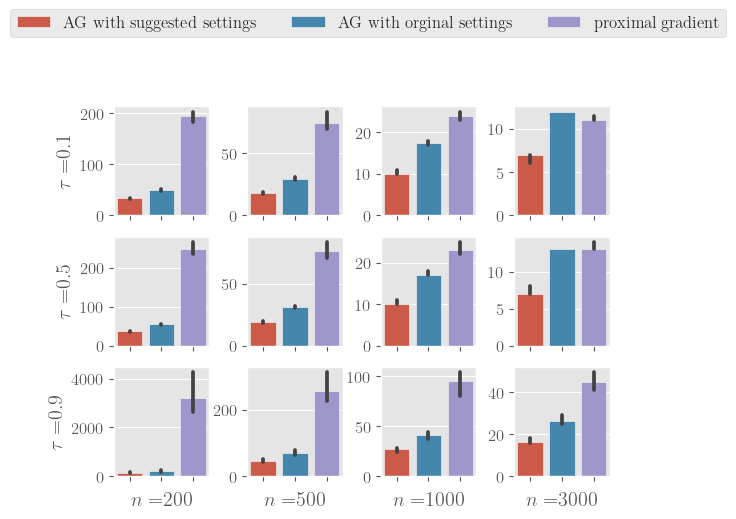

In [16]:
fig, axes = plt.subplots(3, 4)

tau = np.array([.1, .5, .9])
N = np.array([200, 500, 1000, 3000])

for i, j in itertools.product(range(3), range(4)):
    df = pd.DataFrame(columns=[
        'AG with suggested settings', 'proximal gradient',
        'AG with orginal settings'
    ],
                      data=SCAD_sim_results[i, j, ...])
    df_melted = pd.melt(df,
                        id_vars=[],
                        value_vars=[
                            'AG with suggested settings',
                            'AG with orginal settings', 'proximal gradient'
                        ],
                        var_name='method',
                        value_name='k')
    #     sns.boxplot(ax=axes[i, j], data=df_melted, x="method", y="k", hue="method", showfliers = False)#.set_title(r'$\tau=$'+str(tau[i])+'$, N=$'+str(N[j]))
    sns.barplot(ax=axes[i, j],
                data=df_melted,
                x="method",
                y="k",
                hue="method",
                estimator=np.median,
                ci=95,
                dodge=False)  #, palette = "Greys")
    if i == 2 and j != 0:
        axes[i, j].set(xticklabels=[], xlabel=r"$n=$" + str(N[j]),
                       ylabel=None)  # yticklabels=[] to remove y scales
    if j == 0 and i != 2:
        axes[i, j].set(xticklabels=[],
                       xlabel=None,
                       ylabel=r"$\tau=$" + str(tau[i]))
    axes[2, 0].set(xticklabels=[],
                   xlabel=r"$n=$" + str(N[0]),
                   ylabel=r"$\tau=$" + str(tau[2]))
    if i != 2 and j != 0:
        axes[i, j].set(xticklabels=[], xlabel=None, ylabel=None)

    axes[i, j].get_legend().remove()

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles,
           labels,
           loc='upper left',
           ncol=3,
           bbox_to_anchor=(-.05, 1.1))
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=.4,
                    hspace=None)

#plt.tight_layout()
plt.savefig('logistic-fig_k_SCAD.eps',
            format='eps',
            dpi=600,
            bbox_inches='tight')
plt.show()

### MCP

In [17]:
MCP_sim_results = np.load("./tasks/task2speed/MCP_sim_results.npy")

MCP_sim_results_mean = np.median(MCP_sim_results, 2)
print("Median:")
print("AG: ", MCP_sim_results_mean[..., 0])
print("proximal gradient: ", MCP_sim_results_mean[..., 1])
print("original settings: ", MCP_sim_results_mean[..., 2])
MCP_sim_results_se = np.around(mad(MCP_sim_results, 2) * 1.4826, 3)
print("Scaled MAD: ")
print("AG: ", MCP_sim_results_se[..., 0])
print("proximal gradient: ", MCP_sim_results_se[..., 1])
print("original settings: ", MCP_sim_results_se[..., 2])

logistic_MCP_iterations_latex = pasta(MCP_sim_results_mean, MCP_sim_results_se)

Median:
AG:  [[22.  29.5 10.   7. ]
 [24.  25.  11.   7. ]
 [62.  48.5 27.  18. ]]
proximal gradient:  [[ 80.  187.   22.   11. ]
 [ 96.  123.5  25.5  13. ]
 [598.  264.  106.   49. ]]
original settings:  [[33.  45.  17.  12. ]
 [37.  39.  18.  13. ]
 [92.  72.  43.  28.5]]
Scaled MAD: 
AG:  [[ 1.483 12.602  1.483  0.   ]
 [ 1.483  5.93   1.483  0.   ]
 [14.826 14.085  8.896  5.93 ]]
proximal gradient:  [[  7.413 135.658   2.965   1.483]
 [ 10.378  67.458   6.672   1.483]
 [247.594 137.882  53.374  22.239]]
original settings:  [[ 1.483 18.532  1.483  1.483]
 [ 2.965  9.637  2.965  1.483]
 [20.756 20.756 13.343  8.154]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


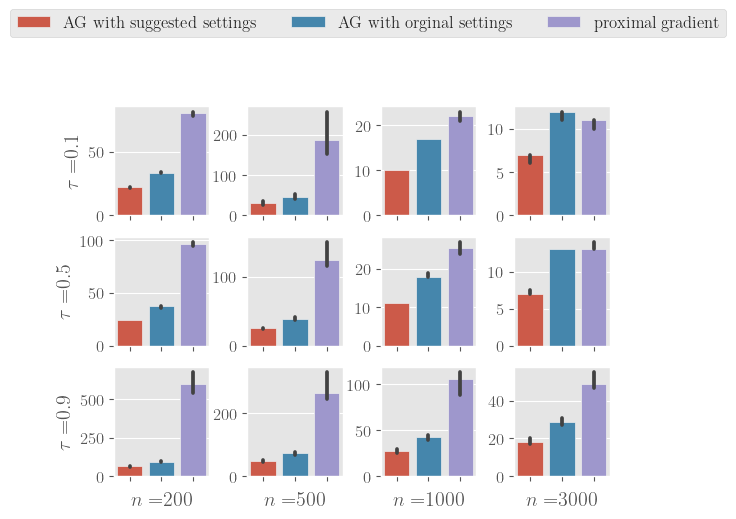

In [18]:
fig, axes = plt.subplots(3, 4)

tau = np.array([.1, .5, .9])
N = np.array([200, 500, 1000, 3000])

for i, j in itertools.product(range(3), range(4)):
    df = pd.DataFrame(columns=[
        'AG with suggested settings', 'proximal gradient',
        'AG with orginal settings'
    ],
                      data=MCP_sim_results[i, j, ...])
    df_melted = pd.melt(df,
                        id_vars=[],
                        value_vars=[
                            'AG with suggested settings',
                            'AG with orginal settings', 'proximal gradient'
                        ],
                        var_name='method',
                        value_name='k')
    #     sns.boxplot(ax=axes[i, j], data=df_melted, x="method", y="k", hue="method", showfliers = False)#.set_title(r'$\tau=$'+str(tau[i])+'$, N=$'+str(N[j]))
    sns.barplot(ax=axes[i, j],
                data=df_melted,
                x="method",
                y="k",
                hue="method",
                estimator=np.median,
                ci=95,
                dodge=False)  #, palette = "Greys")
    if i == 2 and j != 0:
        axes[i, j].set(xticklabels=[], xlabel=r"$n=$" + str(N[j]),
                       ylabel=None)  # yticklabels=[] to remove y scales
    if j == 0 and i != 2:
        axes[i, j].set(xticklabels=[],
                       xlabel=None,
                       ylabel=r"$\tau=$" + str(tau[i]))
    axes[2, 0].set(xticklabels=[],
                   xlabel=r"$n=$" + str(N[0]),
                   ylabel=r"$\tau=$" + str(tau[2]))
    if i != 2 and j != 0:
        axes[i, j].set(xticklabels=[], xlabel=None, ylabel=None)

    axes[i, j].get_legend().remove()

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles,
           labels,
           loc='upper left',
           ncol=3,
           bbox_to_anchor=(-.05, 1.1))
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=.4,
                    hspace=None)

#plt.tight_layout()
plt.savefig('logistic-fig_k_MCP.eps',
            format='eps',
            dpi=600,
            bbox_inches='tight')
plt.show()

# logistic -- Signals
## SCAD
### AG

In [19]:
results_SCAD_signal_recovery = np.load(
    "./tasks/task2/results_SCAD_signal_recovery.npy")

results_SCAD_signal_recovery_mean = np.around(
    np.mean(results_SCAD_signal_recovery, 2), 3)
results_SCAD_signal_recovery_se = np.around(
    np.std(results_SCAD_signal_recovery, 2), 3)
print("Sample mean:")
print(
    "2-norm: ",
    pasta(results_SCAD_signal_recovery_mean[..., 0],
          results_SCAD_signal_recovery_se[..., 0]))
print(
    "infinity-norm: ",
    pasta(results_SCAD_signal_recovery_mean[..., 1],
          results_SCAD_signal_recovery_se[..., 1]))
print(
    "PPV: ",
    pasta(results_SCAD_signal_recovery_mean[..., 2],
          results_SCAD_signal_recovery_se[..., 2]))
print(
    "NPV: ",
    pasta(results_SCAD_signal_recovery_mean[..., 3],
          results_SCAD_signal_recovery_se[..., 3]))
print(
    "active set cardi: ",
    pasta(results_SCAD_signal_recovery_mean[..., 4],
          results_SCAD_signal_recovery_se[..., 4]))

# results_SCAD_signal_recovery_median = cp.median(results_SCAD_signal_recovery, 2)
# print("Sample median:")
# print("2-norm: ",results_SCAD_signal_recovery_median[...,0])
# print("infinity-norm: ",results_SCAD_signal_recovery_median[...,1])
# print("sensitivity: ",results_SCAD_signal_recovery_median[...,2])
# print("specificity: ",results_SCAD_signal_recovery_median[...,3])
# results_SCAD_signal_recovery_mad = mad(results_SCAD_signal_recovery.get(), 2)*1.4826
# print("Scaled MAD:")
# print("2-norm: ",results_SCAD_signal_recovery_mad[...,0])
# print("infinity-norm: ",results_SCAD_signal_recovery_mad[...,1])
# print("sensitivity: ",results_SCAD_signal_recovery_mad[...,2])
# print("specificity: ",results_SCAD_signal_recovery_mad[...,3])

logistic_SCAD_signal_latex = pasta(results_SCAD_signal_recovery_mean,
                                   results_SCAD_signal_recovery_se)

Sample mean:
2-norm:  [['0.762 (0.046)' '0.808 (0.04)' '0.897 (0.034)']
 ['0.553 (0.061)' '0.652 (0.055)' '0.82 (0.054)']
 ['0.393 (0.068)' '0.522 (0.068)' '0.779 (0.074)']
 ['0.319 (0.065)' '0.467 (0.085)' '0.768 (0.087)']]
infinity-norm:  [['2.379 (0.437)' '2.465 (0.408)' '2.747 (0.482)']
 ['2.003 (0.425)' '2.171 (0.402)' '2.632 (0.468)']
 ['1.661 (0.391)' '1.897 (0.371)' '2.615 (0.417)']
 ['1.479 (0.374)' '1.786 (0.39)' '2.577 (0.425)']]
PPV:  [['0.786 (0.082)' '0.775 (0.095)' '0.688 (0.121)']
 ['0.869 (0.06)' '0.853 (0.077)' '0.753 (0.109)']
 ['0.913 (0.045)' '0.873 (0.059)' '0.794 (0.094)']
 ['0.913 (0.048)' '0.88 (0.058)' '0.792 (0.095)']]
NPV:  [['0.982 (0.001)' '0.981 (0.001)' '0.978 (0.0)']
 ['0.985 (0.002)' '0.983 (0.001)' '0.979 (0.001)']
 ['0.987 (0.002)' '0.984 (0.001)' '0.979 (0.001)']
 ['0.988 (0.002)' '0.984 (0.001)' '0.979 (0.001)']]
active set cardi:  [['17.78 (4.063)' '13.78 (3.339)' '7.76 (2.173)']
 ['23.55 (5.222)' '17.24 (3.29)' '9.13 (2.477)']
 ['25.92 (4.064)' '

### ncvreg

In [20]:
results_SCAD_signal_recovery = np.load(
    "./SCAD_MCP/logistic/R_results_SCAD_signal_recovery.npy")
results_SCAD_signal_recovery = np.reshape(results_SCAD_signal_recovery,
                                          (4, 3, 100, 5),
                                          "F")  # keep array dimension true

results_SCAD_signal_recovery_mean = np.around(
    np.mean(results_SCAD_signal_recovery, 2), 3)
results_SCAD_signal_recovery_se = np.around(
    np.std(results_SCAD_signal_recovery, 2), 3)
print("Sample mean:")
print(
    "2-norm: ",
    pasta(results_SCAD_signal_recovery_mean[..., 0],
          results_SCAD_signal_recovery_se[..., 0]))
print(
    "infinity-norm: ",
    pasta(results_SCAD_signal_recovery_mean[..., 1],
          results_SCAD_signal_recovery_se[..., 1]))
print(
    "PPV: ",
    pasta(results_SCAD_signal_recovery_mean[..., 2],
          results_SCAD_signal_recovery_se[..., 2]))
print(
    "NPV: ",
    pasta(results_SCAD_signal_recovery_mean[..., 3],
          results_SCAD_signal_recovery_se[..., 3]))
print(
    "active set cardi: ",
    pasta(results_SCAD_signal_recovery_mean[..., 4],
          results_SCAD_signal_recovery_se[..., 4]))

# results_SCAD_signal_recovery_median = cp.median(results_SCAD_signal_recovery, 2)
# print("Sample median:")
# print("2-norm: ",results_SCAD_signal_recovery_median[...,0])
# print("infinity-norm: ",results_SCAD_signal_recovery_median[...,1])
# print("sensitivity: ",results_SCAD_signal_recovery_median[...,2])
# print("specificity: ",results_SCAD_signal_recovery_median[...,3])
# results_SCAD_signal_recovery_mad = mad(results_SCAD_signal_recovery.get(), 2)*1.4826
# print("Scaled MAD:")
# print("2-norm: ",results_SCAD_signal_recovery_mad[...,0])
# print("infinity-norm: ",results_SCAD_signal_recovery_mad[...,1])
# print("sensitivity: ",results_SCAD_signal_recovery_mad[...,2])
# print("specificity: ",results_SCAD_signal_recovery_mad[...,3])

ncvreg_logistic_SCAD_signal_latex = pasta(results_SCAD_signal_recovery_mean,
                                          results_SCAD_signal_recovery_se)

Sample mean:
2-norm:  [['0.804 (0.036)' '0.84 (0.032)' '0.903 (0.033)']
 ['0.601 (0.05)' '0.68 (0.061)' '0.81 (0.054)']
 ['0.436 (0.062)' '0.537 (0.086)' '0.742 (0.067)']
 ['0.379 (0.067)' '0.481 (0.084)' '0.716 (0.076)']]
infinity-norm:  [['2.446 (0.438)' '2.518 (0.417)' '2.704 (0.49)']
 ['2.095 (0.41)' '2.203 (0.402)' '2.576 (0.426)']
 ['1.773 (0.407)' '1.906 (0.401)' '2.497 (0.407)']
 ['1.625 (0.397)' '1.78 (0.379)' '2.481 (0.374)']]
PPV:  [['0.223 (0.047)' '0.261 (0.072)' '0.308 (0.172)']
 ['0.246 (0.046)' '0.266 (0.077)' '0.271 (0.147)']
 ['0.272 (0.055)' '0.283 (0.068)' '0.275 (0.121)']
 ['0.285 (0.054)' '0.285 (0.068)' '0.275 (0.129)']]
NPV:  [['0.987 (0.002)' '0.985 (0.002)' '0.98 (0.001)']
 ['0.99 (0.002)' '0.987 (0.002)' '0.98 (0.001)']
 ['0.992 (0.002)' '0.988 (0.001)' '0.98 (0.001)']
 ['0.992 (0.002)' '0.989 (0.001)' '0.981 (0.001)']]
active set cardi:  [['117.78 (29.691)' '86.54 (27.524)' '39.6 (20.86)']
 ['133.66 (29.134)' '101.39 (30.161)' '45.59 (19.916)']
 ['129.34 (26

### plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


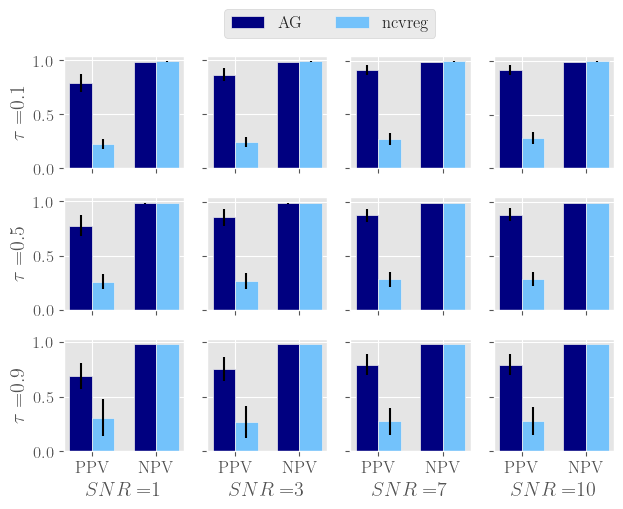

In [21]:
AG = np.load("./tasks/task2/results_SCAD_signal_recovery.npy")
AG_mean = np.mean(AG, 2)
AG_se = np.std(AG, 2)
ncvreg = np.load("./SCAD_MCP/logistic/R_results_SCAD_signal_recovery.npy")
ncvreg = np.reshape(ncvreg, (4, 3, 100, 5), "F")  # keep array dimension true
ncvreg_mean = np.mean(ncvreg, 2)
ncvreg_se = np.std(ncvreg, 2)

fig, axes = plt.subplots(3, 4)

tau = np.array([.1, .5, .9])
SNR = np.array([1, 3, 7, 10])

for i, j in itertools.product(range(3), range(4)):
    data = np.array([[AG_mean[j, i, 2], ncvreg_mean[j, i, 2]],
                     [AG_mean[j, i, 3], ncvreg_mean[j, i, 3]]])
    data_se = np.array([[AG_se[j, i, 2], ncvreg_se[j, i, 2]],
                        [AG_se[j, i, 3], ncvreg_se[j, i, 3]]])
    length = len(data)
    x_labels = ["PPV", "NPV"]
    width = 0.35  # width of bar
    x = np.arange(length)
    axes[i, j].bar(x,
                   data[:, 0],
                   width,
                   color='#000080',
                   label='AG',
                   yerr=data_se[:, 0])
    axes[i, j].bar(x + width,
                   data[:, 1],
                   width,
                   color='#73C2FB',
                   label='ncvreg',
                   yerr=data_se[:, 1])
    #     ax.set_ylabel('Proportion')
    #     ax.set_ylim(0,75)
    axes[i, j].set_xticks(x + width / 2)
    axes[i, j].set_xticklabels(x_labels)
    axes[i, j].set_xlabel('Predicted Values')
    #     ax.set_title('Title')
    #     axes[i,j].legend()

    if i == 2 and j != 0:
        axes[i, j].set(xticklabels=x_labels,
                       xlabel=r"$SNR=$" + str(SNR[j]),
                       ylabel=None)  # yticklabels=[] to remove y scales
    if j == 0 and i != 2:
        axes[i, j].set(xticklabels=x_labels,
                       xlabel=None,
                       ylabel=r"$\tau=$" + str(tau[i]))
    axes[2, 0].set(xticklabels=x_labels,
                   xlabel=r"$SNR=$" + str(SNR[0]),
                   ylabel=r"$\tau=$" + str(tau[2]))
    if i != 2 and j != 0:
        axes[i, j].set(xticklabels=x_labels, xlabel=None, ylabel=None)

for ax in axes.flat:
    ax.label_outer()

# plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
fig.tight_layout(pad=.2)
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles,
           labels,
           loc='upper left',
           ncol=4,
           bbox_to_anchor=(.35, 1.075))

plt.tight_layout()
plt.savefig('logistic-SCAD-pv.eps', format='eps', dpi=600, bbox_inches='tight')
plt.show()

## MCP
### AG

In [22]:
results_MCP_signal_recovery = np.load(
    "./tasks/task2/results_MCP_signal_recovery.npy")

results_MCP_signal_recovery_mean = np.around(
    np.mean(results_MCP_signal_recovery, 2), 3)
results_MCP_signal_recovery_se = np.around(
    np.std(results_MCP_signal_recovery, 2), 3)
print("Sample mean:")
print(
    "2-norm: ",
    pasta(results_MCP_signal_recovery_mean[..., 0],
          results_MCP_signal_recovery_se[..., 0]))
print(
    "infinity-norm: ",
    pasta(results_MCP_signal_recovery_mean[..., 1],
          results_MCP_signal_recovery_se[..., 1]))
print(
    "PPV: ",
    pasta(results_MCP_signal_recovery_mean[..., 2],
          results_MCP_signal_recovery_se[..., 2]))
print(
    "NPV: ",
    pasta(results_MCP_signal_recovery_mean[..., 3],
          results_MCP_signal_recovery_se[..., 3]))
print(
    "active set cardi: ",
    pasta(results_MCP_signal_recovery_mean[..., 4],
          results_MCP_signal_recovery_se[..., 4]))

# results_MCP_signal_recovery_median = cp.median(results_MCP_signal_recovery, 2)
# print("Sample median:")
# print("2-norm: ",results_MCP_signal_recovery_median[...,0])
# print("infinity-norm: ",results_MCP_signal_recovery_median[...,1])
# print("sensitivity: ",results_MCP_signal_recovery_median[...,2])
# print("specificity: ",results_MCP_signal_recovery_median[...,3])
# results_MCP_signal_recovery_mad = mad(results_MCP_signal_recovery.get(), 2)*1.4826
# print("Scaled MAD:")
# print("2-norm: ",results_MCP_signal_recovery_mad[...,0])
# print("infinity-norm: ",results_MCP_signal_recovery_mad[...,1])
# print("sensitivity: ",results_MCP_signal_recovery_mad[...,2])
# print("specificity: ",results_MCP_signal_recovery_mad[...,3])

logistic_MCP_signal_latex = pasta(results_MCP_signal_recovery_mean,
                                  results_MCP_signal_recovery_se)

Sample mean:
2-norm:  [['0.76 (0.045)' '0.808 (0.041)' '0.895 (0.035)']
 ['0.551 (0.065)' '0.654 (0.06)' '0.819 (0.056)']
 ['0.387 (0.073)' '0.522 (0.074)' '0.767 (0.071)']
 ['0.316 (0.068)' '0.466 (0.08)' '0.762 (0.079)']]
infinity-norm:  [['2.379 (0.441)' '2.469 (0.408)' '2.735 (0.476)']
 ['2.005 (0.426)' '2.172 (0.41)' '2.621 (0.452)']
 ['1.651 (0.401)' '1.894 (0.377)' '2.578 (0.422)']
 ['1.473 (0.376)' '1.788 (0.383)' '2.586 (0.434)']]
PPV:  [['0.872 (0.06)' '0.866 (0.055)' '0.776 (0.106)']
 ['0.903 (0.046)' '0.886 (0.058)' '0.788 (0.097)']
 ['0.922 (0.041)' '0.899 (0.053)' '0.811 (0.084)']
 ['0.921 (0.039)' '0.897 (0.054)' '0.795 (0.103)']]
NPV:  [['0.982 (0.001)' '0.98 (0.001)' '0.978 (0.001)']
 ['0.985 (0.002)' '0.982 (0.001)' '0.979 (0.001)']
 ['0.987 (0.002)' '0.984 (0.001)' '0.98 (0.001)']
 ['0.988 (0.002)' '0.984 (0.001)' '0.98 (0.001)']]
active set cardi:  [['14.62 (3.61)' '11.27 (2.561)' '7.04 (2.135)']
 ['22.06 (5.093)' '16.08 (3.638)' '9.05 (2.251)']
 ['25.56 (4.435)' '1

### ncvreg

In [23]:
results_MCP_signal_recovery = np.load(
    "./SCAD_MCP/logistic/R_results_MCP_signal_recovery.npy")
results_MCP_signal_recovery = np.reshape(results_MCP_signal_recovery,
                                         (4, 3, 100, 5),
                                         "F")  # keep array dimension true

results_MCP_signal_recovery_mean = np.around(
    np.mean(results_MCP_signal_recovery, 2), 3)
results_MCP_signal_recovery_se = np.around(
    np.std(results_MCP_signal_recovery, 2), 3)
print("Sample mean:")
print(
    "2-norm: ",
    pasta(results_MCP_signal_recovery_mean[..., 0],
          results_MCP_signal_recovery_se[..., 0]))
print(
    "infinity-norm: ",
    pasta(results_MCP_signal_recovery_mean[..., 1],
          results_MCP_signal_recovery_se[..., 1]))
print(
    "PPV: ",
    pasta(results_MCP_signal_recovery_mean[..., 2],
          results_MCP_signal_recovery_se[..., 2]))
print(
    "NPV: ",
    pasta(results_MCP_signal_recovery_mean[..., 3],
          results_MCP_signal_recovery_se[..., 3]))
print(
    "active set cardi: ",
    pasta(results_SCAD_signal_recovery_mean[..., 4],
          results_MCP_signal_recovery_se[..., 4]))

# results_MCP_signal_recovery_median = cp.median(results_MCP_signal_recovery, 2)
# print("Sample median:")
# print("2-norm: ",results_MCP_signal_recovery_median[...,0])
# print("infinity-norm: ",results_MCP_signal_recovery_median[...,1])
# print("sensitivity: ",results_MCP_signal_recovery_median[...,2])
# print("specificity: ",results_MCP_signal_recovery_median[...,3])
# results_MCP_signal_recovery_mad = mad(results_MCP_signal_recovery.get(), 2)*1.4826
# print("Scaled MAD:")
# print("2-norm: ",results_MCP_signal_recovery_mad[...,0])
# print("infinity-norm: ",results_MCP_signal_recovery_mad[...,1])
# print("sensitivity: ",results_MCP_signal_recovery_mad[...,2])
# print("specificity: ",results_MCP_signal_recovery_mad[...,3])

ncvreg_logistic_MCP_signal_latex = pasta(results_MCP_signal_recovery_mean,
                                         results_MCP_signal_recovery_se)

Sample mean:
2-norm:  [['0.796 (0.034)' '0.83 (0.032)' '0.904 (0.035)']
 ['0.598 (0.05)' '0.668 (0.061)' '0.827 (0.055)']
 ['0.434 (0.057)' '0.537 (0.074)' '0.754 (0.07)']
 ['0.381 (0.059)' '0.474 (0.08)' '0.741 (0.075)']]
infinity-norm:  [['2.439 (0.442)' '2.501 (0.416)' '2.719 (0.471)']
 ['2.098 (0.414)' '2.187 (0.402)' '2.606 (0.424)']
 ['1.772 (0.402)' '1.91 (0.385)' '2.554 (0.459)']
 ['1.644 (0.389)' '1.77 (0.382)' '2.54 (0.437)']]
PPV:  [['0.378 (0.074)' '0.4 (0.1)' '0.382 (0.154)']
 ['0.427 (0.075)' '0.424 (0.096)' '0.399 (0.142)']
 ['0.468 (0.073)' '0.467 (0.097)' '0.429 (0.139)']
 ['0.493 (0.069)' '0.475 (0.101)' '0.427 (0.149)']]
NPV:  [['0.986 (0.002)' '0.983 (0.001)' '0.978 (0.001)']
 ['0.989 (0.002)' '0.985 (0.001)' '0.979 (0.001)']
 ['0.99 (0.002)' '0.986 (0.001)' '0.98 (0.001)']
 ['0.991 (0.002)' '0.987 (0.001)' '0.98 (0.001)']]
active set cardi:  [['117.78 (13.338)' '86.54 (12.134)' '39.6 (8.82)']
 ['133.66 (14.005)' '101.39 (15.427)' '45.59 (8.351)']
 ['129.34 (12.959)

### plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


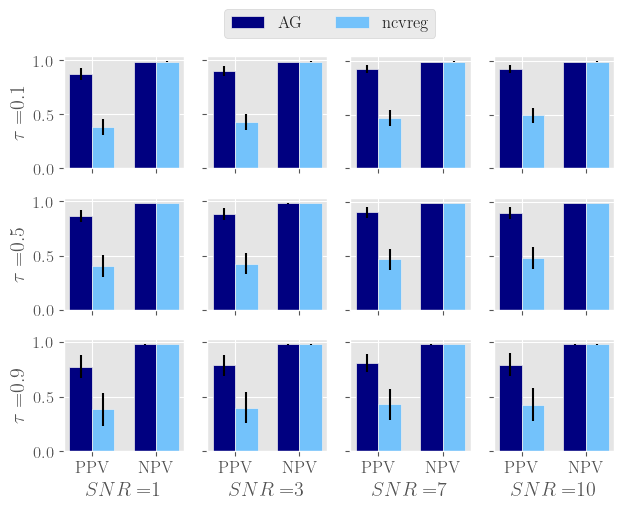

In [24]:
AG = np.load("./tasks/task2/results_MCP_signal_recovery.npy")
AG_mean = np.mean(AG, 2)
AG_se = np.std(AG, 2)
ncvreg = np.load("./SCAD_MCP/logistic/R_results_MCP_signal_recovery.npy")
ncvreg = np.reshape(ncvreg, (4, 3, 100, 5), "F")  # keep array dimension true
ncvreg_mean = np.mean(ncvreg, 2)
ncvreg_se = np.std(ncvreg, 2)

fig, axes = plt.subplots(3, 4)

tau = np.array([.1, .5, .9])
SNR = np.array([1, 3, 7, 10])

for i, j in itertools.product(range(3), range(4)):
    data = np.array([[AG_mean[j, i, 2], ncvreg_mean[j, i, 2]],
                     [AG_mean[j, i, 3], ncvreg_mean[j, i, 3]]])
    data_se = np.array([[AG_se[j, i, 2], ncvreg_se[j, i, 2]],
                        [AG_se[j, i, 3], ncvreg_se[j, i, 3]]])
    length = len(data)
    x_labels = ["PPV", "NPV"]
    width = 0.35  # width of bar
    x = np.arange(length)
    axes[i, j].bar(x,
                   data[:, 0],
                   width,
                   color='#000080',
                   label='AG',
                   yerr=data_se[:, 0])
    axes[i, j].bar(x + width,
                   data[:, 1],
                   width,
                   color='#73C2FB',
                   label='ncvreg',
                   yerr=data_se[:, 1])
    #     ax.set_ylabel('Proportion')
    #     ax.set_ylim(0,75)
    axes[i, j].set_xticks(x + width / 2)
    axes[i, j].set_xticklabels(x_labels)
    axes[i, j].set_xlabel('Predicted Values')
    #     ax.set_title('Title')
    #     axes[i,j].legend()

    if i == 2 and j != 0:
        axes[i, j].set(xticklabels=x_labels,
                       xlabel=r"$SNR=$" + str(SNR[j]),
                       ylabel=None)  # yticklabels=[] to remove y scales
    if j == 0 and i != 2:
        axes[i, j].set(xticklabels=x_labels,
                       xlabel=None,
                       ylabel=r"$\tau=$" + str(tau[i]))
    axes[2, 0].set(xticklabels=x_labels,
                   xlabel=r"$SNR=$" + str(SNR[0]),
                   ylabel=r"$\tau=$" + str(tau[2]))
    if i != 2 and j != 0:
        axes[i, j].set(xticklabels=x_labels, xlabel=None, ylabel=None)

for ax in axes.flat:
    ax.label_outer()

# plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
fig.tight_layout(pad=.2)
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles,
           labels,
           loc='upper left',
           ncol=4,
           bbox_to_anchor=(.35, 1.075))

plt.tight_layout()
plt.savefig('logistic-MCP-pv.eps', format='eps', dpi=600, bbox_inches='tight')
plt.show()

# LaTeX output

In [25]:
def merge_row_by_row(A, B):
    nrow, ncol = A.shape
    _nrow, _ncol = B.shape
    assert nrow == _nrow and ncol == _ncol
    C = np.empty((nrow * 2, ncol), dtype=A.dtype)
    C[np.arange(nrow) * 2, :] = A
    C[np.arange(nrow) * 2 + 1, :] = B
    return C


def dollar(x):
    return "$" + x + "$"


def output_latex(A, B):
    output = pd.DataFrame(merge_row_by_row(A, B))
    return output.to_latex(formatters=[dollar, dollar, dollar],
                           header=[r"$\tau$=0.1", r"$0.5$", r"$0.9$"])

In [26]:
print("signal recovery for LM SCAD")
for j in [0,2,3,4]:
    print(
        output_latex(LM_SCAD_signal_latex[..., j],
                     ncvreg_LM_SCAD_signal_latex[..., j]))

signal recovery for LM SCAD
\begin{tabular}{llll}
\toprule
{} &       \$\textbackslash tau\$=0.1 &            \$0.5\$ &            \$0.9\$ \\
\midrule
0 &  \$0.129 (0.021)\$ &  \$0.504 (0.103)\$ &  \$2.859 (0.493)\$ \\
1 &   \$0.131 (0.02)\$ &  \$0.493 (0.101)\$ &  \$2.932 (0.577)\$ \\
2 &  \$0.051 (0.009)\$ &  \$0.155 (0.027)\$ &  \$2.038 (0.328)\$ \\
3 &  \$0.053 (0.009)\$ &  \$0.157 (0.029)\$ &  \$2.082 (0.336)\$ \\
4 &  \$0.022 (0.004)\$ &  \$0.084 (0.014)\$ &   \$1.27 (0.272)\$ \\
5 &  \$0.022 (0.004)\$ &  \$0.083 (0.014)\$ &  \$1.297 (0.257)\$ \\
6 &  \$0.016 (0.003)\$ &  \$0.063 (0.012)\$ &  \$1.167 (0.199)\$ \\
7 &  \$0.016 (0.003)\$ &  \$0.063 (0.012)\$ &  \$1.152 (0.214)\$ \\
\bottomrule
\end{tabular}

\begin{tabular}{llll}
\toprule
{} &       \$\textbackslash tau\$=0.1 &            \$0.5\$ &            \$0.9\$ \\
\midrule
0 &   \$0.751 (0.13)\$ &   \$0.587 (0.19)\$ &  \$0.493 (0.252)\$ \\
1 &  \$0.254 (0.078)\$ &  \$0.277 (0.123)\$ &  \$0.287 (0.201)\$ \\
2 &  \$0.646 (0.168

In [27]:
print("signal recovery for LM MCP")
for j in [0,2,3,4]:
    print(
        output_latex(LM_MCP_signal_latex[..., j],
                     ncvreg_LM_MCP_signal_latex[..., j]))

signal recovery for LM MCP
\begin{tabular}{llll}
\toprule
{} &       \$\textbackslash tau\$=0.1 &            \$0.5\$ &            \$0.9\$ \\
\midrule
0 &  \$0.134 (0.024)\$ &  \$0.543 (0.117)\$ &   \$2.955 (0.51)\$ \\
1 &  \$0.127 (0.021)\$ &  \$0.495 (0.112)\$ &  \$2.848 (0.375)\$ \\
2 &    \$0.05 (0.01)\$ &  \$0.168 (0.032)\$ &  \$1.946 (0.333)\$ \\
3 &   \$0.05 (0.009)\$ &  \$0.164 (0.033)\$ &  \$1.876 (0.337)\$ \\
4 &  \$0.022 (0.004)\$ &  \$0.088 (0.015)\$ &    \$1.507 (0.3)\$ \\
5 &  \$0.021 (0.004)\$ &  \$0.085 (0.014)\$ &  \$1.443 (0.261)\$ \\
6 &  \$0.015 (0.003)\$ &  \$0.059 (0.012)\$ &  \$1.079 (0.285)\$ \\
7 &  \$0.014 (0.003)\$ &  \$0.059 (0.012)\$ &  \$1.104 (0.211)\$ \\
\bottomrule
\end{tabular}

\begin{tabular}{llll}
\toprule
{} &       \$\textbackslash tau\$=0.1 &            \$0.5\$ &            \$0.9\$ \\
\midrule
0 &  \$0.855 (0.095)\$ &   \$0.738 (0.16)\$ &  \$0.687 (0.181)\$ \\
1 &  \$0.439 (0.105)\$ &  \$0.392 (0.119)\$ &  \$0.385 (0.178)\$ \\
2 &  \$0.842 (0.109)

In [28]:
print("signal recovery for logistic SCAD")
for j in [0,2,3,4]:
    print(
        output_latex(logistic_SCAD_signal_latex[..., j],
                     ncvreg_logistic_SCAD_signal_latex[..., j]))

signal recovery for logistic SCAD
\begin{tabular}{llll}
\toprule
{} &       \$\textbackslash tau\$=0.1 &            \$0.5\$ &            \$0.9\$ \\
\midrule
0 &  \$0.762 (0.046)\$ &   \$0.808 (0.04)\$ &  \$0.897 (0.034)\$ \\
1 &  \$0.804 (0.036)\$ &   \$0.84 (0.032)\$ &  \$0.903 (0.033)\$ \\
2 &  \$0.553 (0.061)\$ &  \$0.652 (0.055)\$ &   \$0.82 (0.054)\$ \\
3 &   \$0.601 (0.05)\$ &   \$0.68 (0.061)\$ &   \$0.81 (0.054)\$ \\
4 &  \$0.393 (0.068)\$ &  \$0.522 (0.068)\$ &  \$0.779 (0.074)\$ \\
5 &  \$0.436 (0.062)\$ &  \$0.537 (0.086)\$ &  \$0.742 (0.067)\$ \\
6 &  \$0.319 (0.065)\$ &  \$0.467 (0.085)\$ &  \$0.768 (0.087)\$ \\
7 &  \$0.379 (0.067)\$ &  \$0.481 (0.084)\$ &  \$0.716 (0.076)\$ \\
\bottomrule
\end{tabular}

\begin{tabular}{llll}
\toprule
{} &       \$\textbackslash tau\$=0.1 &            \$0.5\$ &            \$0.9\$ \\
\midrule
0 &  \$0.786 (0.082)\$ &  \$0.775 (0.095)\$ &  \$0.688 (0.121)\$ \\
1 &  \$0.223 (0.047)\$ &  \$0.261 (0.072)\$ &  \$0.308 (0.172)\$ \\
2 &   \$0.869

In [29]:
print("signal recovery for logistic MCP")
for j in [0,2,3,4]:
    print(
        output_latex(logistic_MCP_signal_latex[..., j],
                     ncvreg_logistic_MCP_signal_latex[..., j]))

signal recovery for logistic MCP
\begin{tabular}{llll}
\toprule
{} &       \$\textbackslash tau\$=0.1 &            \$0.5\$ &            \$0.9\$ \\
\midrule
0 &   \$0.76 (0.045)\$ &  \$0.808 (0.041)\$ &  \$0.895 (0.035)\$ \\
1 &  \$0.796 (0.034)\$ &   \$0.83 (0.032)\$ &  \$0.904 (0.035)\$ \\
2 &  \$0.551 (0.065)\$ &   \$0.654 (0.06)\$ &  \$0.819 (0.056)\$ \\
3 &   \$0.598 (0.05)\$ &  \$0.668 (0.061)\$ &  \$0.827 (0.055)\$ \\
4 &  \$0.387 (0.073)\$ &  \$0.522 (0.074)\$ &  \$0.767 (0.071)\$ \\
5 &  \$0.434 (0.057)\$ &  \$0.537 (0.074)\$ &   \$0.754 (0.07)\$ \\
6 &  \$0.316 (0.068)\$ &   \$0.466 (0.08)\$ &  \$0.762 (0.079)\$ \\
7 &  \$0.381 (0.059)\$ &   \$0.474 (0.08)\$ &  \$0.741 (0.075)\$ \\
\bottomrule
\end{tabular}

\begin{tabular}{llll}
\toprule
{} &       \$\textbackslash tau\$=0.1 &            \$0.5\$ &            \$0.9\$ \\
\midrule
0 &   \$0.872 (0.06)\$ &  \$0.866 (0.055)\$ &  \$0.776 (0.106)\$ \\
1 &  \$0.378 (0.074)\$ &      \$0.4 (0.1)\$ &  \$0.382 (0.154)\$ \\
2 &  \$0.903 (